<a href="https://colab.research.google.com/github/Jass1313c/comp215/blob/main/Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import datetime, json, requests
from pprint import pprint

param = { "format": "geojson", "starttime": "2024-03-10","limit": 20000, "endtime": "2024-05-30"}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
response = requests.get(url, params=param)
data = json.loads(response.text)

pprint(data)

for feature in data['features']:
  depth = feature['geometry']['coordinates'][2]
  if depth < 10 and "Texas" in feature['properties']['place']:
    Latitude = feature['geometry']['coordinates'][1]
    Longitude = feature['geometry']['coordinates'][0]
    print(f"Mag: {feature['properties']['mag']},   Place: {feature['properties']['place']},   Time: {datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000)},   Lat: {Latitude},   Long: {Longitude}")

In [ ]:
import datetime, json, requests
from pprint import pprint
import pyproj

param = { "format": "geojson", "starttime": "2024-03-14","limit": 20000, "endtime": "2024-06-15", "minmagnitude": 1}
url = "https://earthquake.usgs.gov/fdsnws/event/1/query"
response = requests.get(url, params=param)
data = json.loads(response.text)

count = 0
earthquake_data = []

for feature in data['features']:
  depth = feature['geometry']['coordinates'][2]
  if depth < 10 and "Texas" in feature['properties']['place']:
    count += 1

    time = datetime.datetime.fromtimestamp(feature['properties']['time'] / 1000)

    earthquake_data.append({
      "Mag": feature['properties']['mag'],
      "Place": feature['properties']['place'],
      "Time": time,
      "Lat": feature['geometry']['coordinates'][1],
      "Long": feature['geometry']['coordinates'][0],
      "Depth": depth
    })

pprint(earthquake_data)
pprint(f"Count: {count}")

In [ ]:
#Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import pyproj

file_path = '/content/drive/MyDrive/Fracking.csv'
fracking_df = pd.read_csv(file_path)

#Converting coordinate systems to WGS84
source_crs = 'epsg:4269'  # NAD83
target_crs = 'epsg:4326'  # WGS84

pd.set_option('display.max_rows', None)

transformer = pyproj.Transformer.from_crs(source_crs, target_crs)

fracking_df['Latitude_WGS84'], fracking_df['Longitude_WGS84'] = transformer.transform(fracking_df['Latitude'].values, fracking_df['Longitude'].values)

#convert jobstart date into datetime object
fracking_df['JobStartDate'] = pd.to_datetime(fracking_df['JobStartDate'])

#convert jobend date into datetime object
fracking_df['JobEndDate'] = pd.to_datetime(fracking_df['JobEndDate'])

display(fracking_df[['JobStartDate','JobEndDate']])


In [ ]:
filtered_fracking_df = fracking_df[ (fracking_df['Longitude_WGS84'] >= -104.05) & (fracking_df['Longitude_WGS84'] <= -103.85)]

# Get the latitudes and longitudes of the filtered fracking sites
frac_lats = filtered_fracking_df['Latitude_WGS84'].tolist()
frac_lons = filtered_fracking_df['Longitude_WGS84'].tolist()
frac_counties = filtered_fracking_df['CountyName'].tolist()

# Print the coordinates
for lat, lon, county in zip(frac_lats, frac_lons, frac_counties):
    print(f"Latitude: {lat},      Longitude: {lon},      County: {county}")

Latitude: 31.569435,      Longitude: -103.89958,      County: Reeves
Latitude: 31.569435,      Longitude: -103.89964,      County: Reeves
Latitude: 31.569435,      Longitude: -103.89977,      County: Reeves


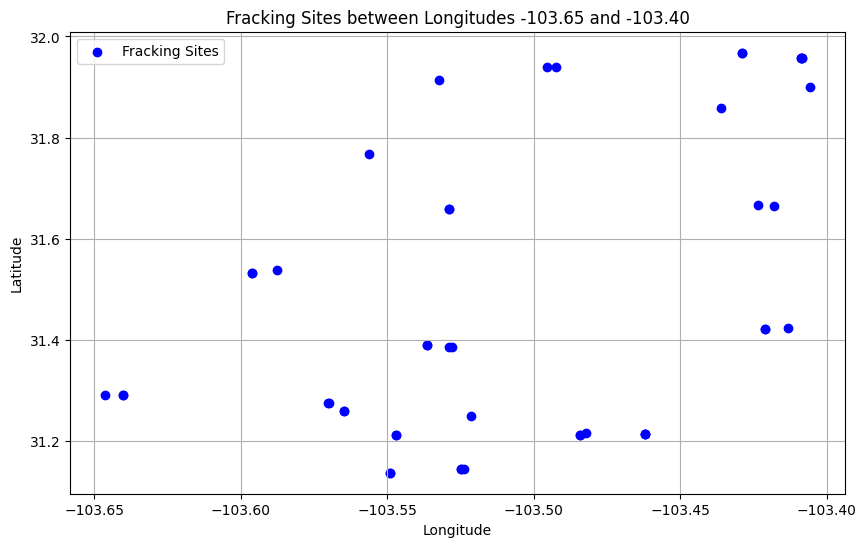

In [ ]:
import matplotlib.pyplot as plt

# Assuming you have already filtered the DataFrame as described in the previous response:
# filtered_fracking_df = fracking_df[(fracking_df['Longitude_WGS84'] >= -103.65) & (fracking_df['Longitude_WGS84'] <= -103.40)]

# Get the latitudes and longitudes of the filtered fracking sites
frac_lats = filtered_fracking_df['Latitude_WGS84'].tolist()
frac_lons = filtered_fracking_df['Longitude_WGS84'].tolist()

# Create a scatter plot
plt.figure(figsize=(10, 6))  # Adjust figure size as needed
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking Sites between Longitudes -103.65 and -103.40')
plt.grid(True)
plt.legend()
plt.show()

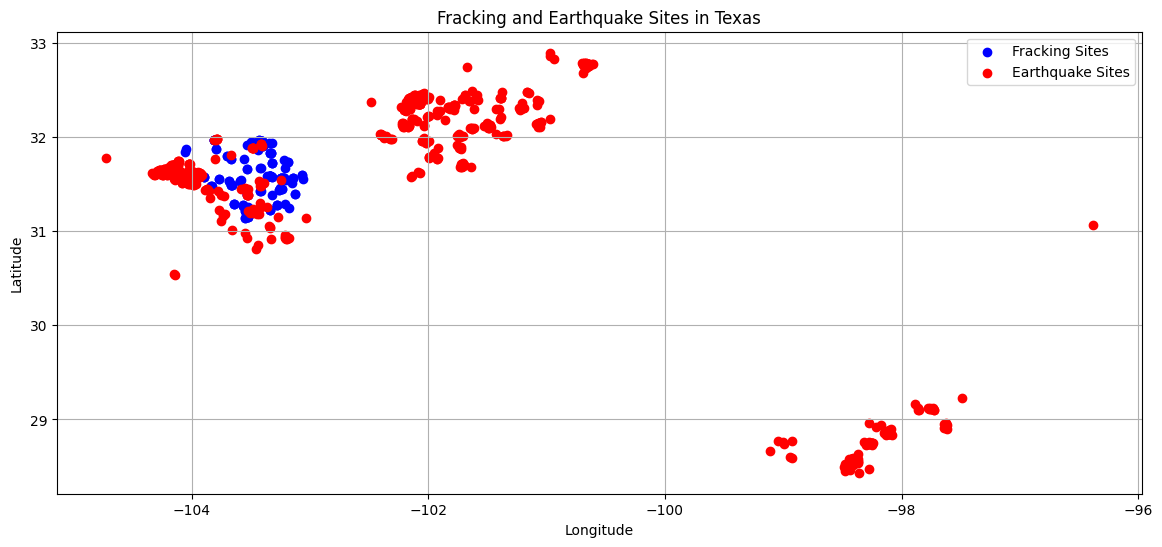

In [26]:
import matplotlib.pyplot as plt

frac_lats = fracking_df['Latitude_WGS84'].tolist()
frac_lons = fracking_df['Longitude_WGS84'].tolist()


eq_lats = [eq['Lat'] for eq in earthquake_data]
eq_lons = [eq['Long'] for eq in earthquake_data]

plt.figure(figsize=(14, 6))


plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')

plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking and Earthquake Sites in Texas')
plt.grid(True)
plt.legend()
plt.show()

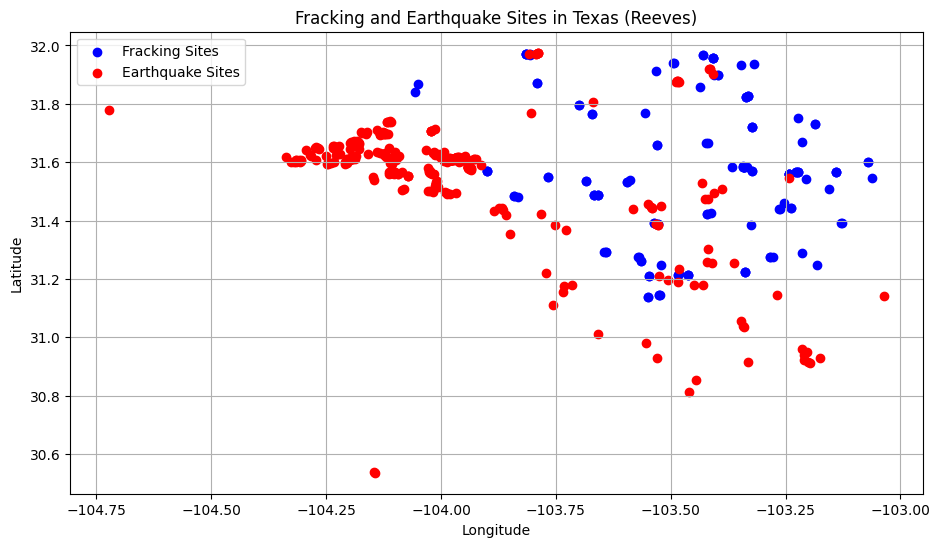

In [32]:
filtered_earthquake_data = [eq for eq in earthquake_data if eq['Long'] < -102.5]
import matplotlib.pyplot as plt

frac_lats = fracking_df['Latitude_WGS84'].tolist()
frac_lons = fracking_df['Longitude_WGS84'].tolist()

eq_lats = [eq['Lat'] for eq in filtered_earthquake_data]
eq_lons = [eq['Long'] for eq in filtered_earthquake_data]

plt.figure(figsize=(11, 6))
plt.scatter(frac_lons, frac_lats, color='blue', label='Fracking Sites')
plt.scatter(eq_lons, eq_lats, color='red', label='Earthquake Sites')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Fracking and Earthquake Sites in Texas (Reeves)')
plt.grid(True)
plt.legend()
plt.show()

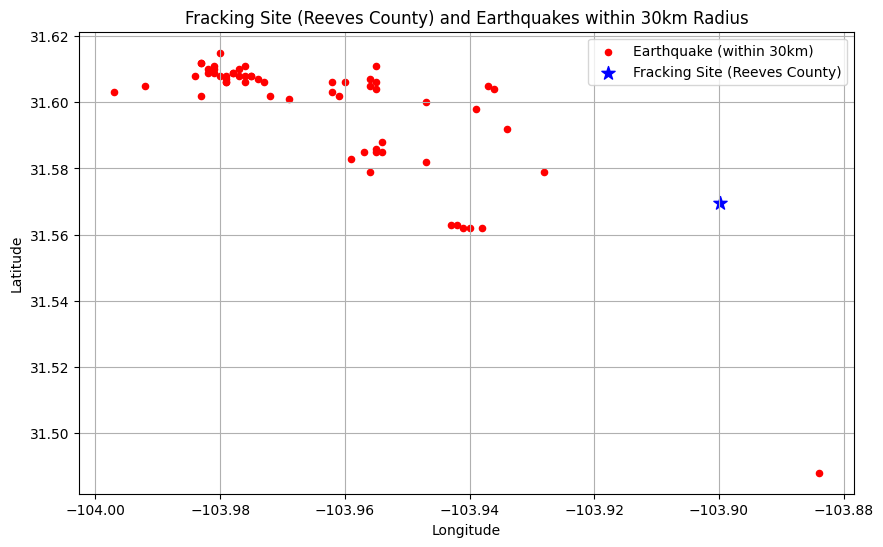

In [ ]:
import matplotlib.pyplot as plt
from geopy.distance import geodesic

# Fracking site coordinates
frac_site = (31.569435, -103.89977)  # Reeves County

# Function to calculate distance
def distance(point1, point2):
    return geodesic(point1, point2).kilometers

# Create figure and axes
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot fracking site
ax.scatter(frac_site[1], frac_site[0], color='blue', marker='*', s=100, label='Fracking Site (Reeves County)')

# Plot earthquakes within 30km radius
for eq in earthquake_data:
    eq_coords = (eq['Lat'], eq['Long'])
    if distance(frac_site, eq_coords) <= 10:
        ax.scatter(eq['Long'], eq['Lat'], color='red', marker='o', s=20, label='Earthquake (within 30km)')

# Customize plot
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Fracking Site (Reeves County) and Earthquakes within 30km Radius')
ax.grid(True)

# Adjust legend to avoid duplicate labels
handles, labels = ax.get_legend_handles_labels()
unique_labels = list(set(labels))
unique_handles = [handles[labels.index(label)] for label in unique_labels]
ax.legend(unique_handles, unique_labels, loc='best')

plt.show()

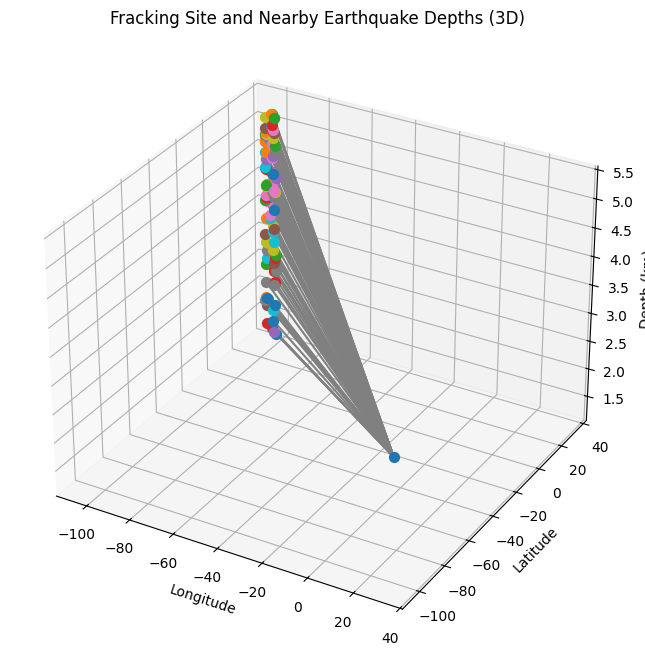

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Assuming you have 'fracking_df' and 'earthquake_data' loaded

# Choose a specific fracking site (e.g., the first one)
frac_site_data = fracking_df.iloc[0]
frac_site_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], frac_site_data['TVD(Km)'])

# Create a graph
graph = nx.Graph()

# Add the fracking site as a node
graph.add_node("Fracking Site", pos=frac_site_coords)

# Add nodes for earthquake depths near the fracking site's depth
threshold_depth_difference = 2  # Adjust as needed
for eq in earthquake_data:
    if abs(frac_site_data['TVD(Km)'] - eq['Depth']) <= threshold_depth_difference:
        graph.add_node(f"Earthquake {eq['Place']}", pos=(eq['Long'], eq['Lat'], eq['Depth']))

# Connect the fracking site node to nearby earthquake depth nodes
for eq_node in [node for node in graph.nodes if 'Earthquake' in node]:
    graph.add_edge("Fracking Site", eq_node)

# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get node positions for plotting
pos = nx.get_node_attributes(graph, 'pos')

# Plot nodes
for node, coords in pos.items():
    ax.scatter(coords[0], coords[1], coords[2], s=50, label=node)

# Plot edges
for edge in graph.edges():
    x = [pos[edge[0]][0], pos[edge[1]][0]]
    y = [pos[edge[0]][1], pos[edge[1]][1]]
    z = [pos[edge[0]][2], pos[edge[1]][2]]
    ax.plot(x, y, z, color='gray')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (km)')
ax.set_title('Fracking Site and Nearby Earthquake Depths (3D)')

# Show legend (if needed)
# ax.legend()

plt.show()

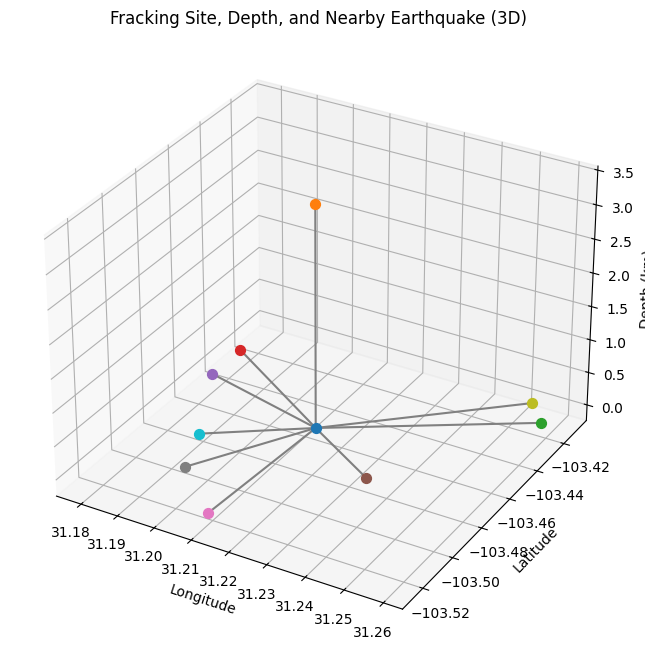

In [45]:
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from geopy.distance import geodesic

# Assuming you have 'fracking_df' and 'earthquake_data' loaded

# Choose a specific fracking site (e.g., the first one)
frac_site_data = fracking_df.iloc[0]
frac_site_surface_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], 0)  # Surface coordinates (z=0)
frac_site_depth_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], frac_site_data['TVD(Km)'])

# Create a graph
graph = nx.Graph()

# Add the fracking site (surface) as a node
graph.add_node("Fracking Site (Surface)", pos=frac_site_surface_coords)

# Add the fracking depth as a node
graph.add_node("Fracking Depth", pos=frac_site_depth_coords)

# Connect the fracking site (surface) to the fracking depth
graph.add_edge("Fracking Site (Surface)", "Fracking Depth")

# Add earthquake site node and connect if within distance threshold
threshold_distance = 10  # Adjust as needed
for eq in earthquake_data:
    eq_coords = (eq['Lat'], eq['Long'], 0)  # Earthquake surface coordinates (z=0)
    distance_to_frac_site = geodesic(frac_site_surface_coords[:2], eq_coords[:2]).kilometers  # Calculate horizontal distance

    if distance_to_frac_site <= threshold_distance:
        graph.add_node(f"Earthquake Site {eq['Place']}", pos=eq_coords)
        graph.add_edge("Fracking Site (Surface)", f"Earthquake Site {eq['Place']}")


# Create a 3D plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Get node positions for plotting
pos = nx.get_node_attributes(graph, 'pos')

# Plot nodes
for node, coords in pos.items():
    ax.scatter(coords[0], coords[1], coords[2], s=50, label=node)

# Plot edges
for edge in graph.edges():
    x = [pos[edge[0]][0], pos[edge[1]][0]]
    y = [pos[edge[0]][1], pos[edge[1]][1]]
    z = [pos[edge[0]][2], pos[edge[1]][2]]
    ax.plot(x, y, z, color='gray')

# Set labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_zlabel('Depth (km)')
ax.set_title('Fracking Site, Depth, and Nearby Earthquake (3D)')

# Show legend (if needed)
# ax.legend()

plt.show()

In [46]:
import networkx as nx
import plotly.graph_objects as go
from geopy.distance import geodesic

# Assuming you have 'fracking_df' and 'earthquake_data' loaded

# Choose a specific fracking site (e.g., the first one)
frac_site_data = fracking_df.iloc[0]
frac_site_surface_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], 0)  # Surface coordinates (z=0)
frac_site_depth_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], frac_site_data['TVD(Km)'])

# Create a graph
graph = nx.Graph()

# Add the fracking site (surface) as a node
graph.add_node("Fracking Site (Surface)", pos=frac_site_surface_coords)

# Add the fracking depth as a node
graph.add_node("Fracking Depth", pos=frac_site_depth_coords)

# Connect the fracking site (surface) to the fracking depth
graph.add_edge("Fracking Site (Surface)", "Fracking Depth")

# Add earthquake site node and connect if within distance threshold
threshold_distance = 10  # Adjust as needed
for eq in earthquake_data:
    eq_coords = (eq['Lat'], eq['Long'], 0)  # Earthquake surface coordinates (z=0)
    distance_to_frac_site = geodesic(frac_site_surface_coords[:2], eq_coords[:2]).kilometers  # Calculate horizontal distance

    if distance_to_frac_site <= threshold_distance:
        graph.add_node(f"Earthquake Site {eq['Place']}", pos=eq_coords)
        graph.add_edge("Fracking Site (Surface)", f"Earthquake Site {eq['Place']}")

# Get node positions for plotting
pos = nx.get_node_attributes(graph, 'pos')

# Create Plotly traces for nodes and edges
node_trace = go.Scatter3d(
    x=[pos[node][0] for node in graph.nodes()],
    y=[pos[node][1] for node in graph.nodes()],
    z=[pos[node][2] for node in graph.nodes()],
    mode='markers',
    marker=dict(size=5, color='blue'),  # Adjust marker properties as needed
    text=list(graph.nodes()),
    hoverinfo='text'
)

edge_trace = go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines',
    line=dict(color='gray', width=2),  # Adjust line properties as needed
    hoverinfo='none'
)

for edge in graph.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    edge_trace['z'] += tuple([z0, z1, None])

# Create the Plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Fracking Site, Depth, and Nearby Earthquake (3D Movable)",
                    scene=dict(
                        xaxis_title="Longitude",
                        yaxis_title="Latitude",
                        zaxis_title="Depth (km)"
                    ),
                    showlegend=False,  # You can set this to True to show a legend
                )
                )

fig.show()

In [47]:
import networkx as nx
import plotly.graph_objects as go
from geopy.distance import geodesic

# ... (Your existing code to load data and create the graph) ...

# Get node positions for plotting and invert z-coordinates
pos = nx.get_node_attributes(graph, 'pos')
for node, coords in pos.items():
    pos[node] = (coords[0], coords[1], -coords[2])  # Invert z-coordinate

# ... (Your existing code to create Plotly traces) ...

# Create the Plotly figure and adjust z-axis range
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Fracking Site, Depth, and Nearby Earthquake (3D Movable)",
                    scene=dict(
                        xaxis_title="Longitude",
                        yaxis_title="Latitude",
                        zaxis_title="Depth (km)",
                        zaxis=dict(autorange="reversed")  # Reverse z-axis range
                    ),
                    showlegend=False,
                )
                )

fig.show()

In [55]:
import networkx as nx
import plotly.graph_objects as go
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Assuming you have 'fracking_df' and 'earthquake_data' loaded

# Choose a specific fracking site (e.g., the first one)
frac_site_data = fracking_df.iloc[49]
frac_site_surface_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], 0)  # Surface coordinates (z=0)
frac_site_depth_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], frac_site_data['TVD(Km)'])

# Create a graph
graph = nx.Graph()

# Add the fracking site (surface) as a node
graph.add_node("Fracking Site (Surface)", pos=frac_site_surface_coords)

# Add the fracking depth as a node
graph.add_node("Fracking Depth", pos=frac_site_depth_coords)

# Connect the fracking site (surface) to the fracking depth
graph.add_edge("Fracking Site (Surface)", "Fracking Depth")

# Add earthquake site nodes (without connecting them to the fracking site)
for eq in earthquake_data:
    eq_coords = (eq['Lat'], eq['Long'], 0)  # Earthquake surface coordinates (z=0)
    graph.add_node(f"Earthquake Site {eq['Place']}", pos=eq_coords)

# Get node positions and invert z-coordinates
pos = nx.get_node_attributes(graph, 'pos')
for node, coords in pos.items():
    pos[node] = (coords[0], coords[1], -coords[2])

# Get earthquake magnitudes and create color scale
eq_magnitudes = [eq['Mag'] for eq in earthquake_data if f"Earthquake Site {eq['Place']}" in graph.nodes()]
color_scale = plt.cm.get_cmap('viridis', len(eq_magnitudes))

# Create Plotly traces for nodes and edges
node_trace = go.Scatter3d(
    x=[pos[node][0] for node in graph.nodes()],
    y=[pos[node][1] for node in graph.nodes()],
    z=[pos[node][2] for node in graph.nodes()],
    mode='markers',
    marker=dict(
        size=5,
        color=[color_scale(i) if 'Earthquake Site' in node else 'blue' for i, node in enumerate(graph.nodes())],
        colorscale='Viridis',
        colorbar=dict(title='Magnitude')
    ),
    text=list(graph.nodes()),
    hoverinfo='text'
)

edge_trace = go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
)

for edge in graph.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    edge_trace['z'] += tuple([z0, z1, None])

# Create the Plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Fracking Site, Depth, and Nearby Earthquake (3D Movable)",
                    scene=dict(
                        xaxis_title="Longitude",
                        yaxis_title="Latitude",
                        zaxis_title="Depth (km)",
                        zaxis=dict(autorange="reversed")
                    ),
                    showlegend=True,
                )
                )

fig.show()

<ipython-input-55-7216a26bace6>:37: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



In [58]:
import networkx as nx
import plotly.graph_objects as go
from geopy.distance import geodesic
import matplotlib.pyplot as plt

# Assuming you have 'fracking_df' and 'earthquake_data' loaded

# Choose a specific fracking site (e.g., the first one)
frac_site_data = fracking_df.iloc[0]  # Using the first fracking site
frac_site_surface_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], 0)  # Surface coordinates (z=0)
frac_site_depth_coords = (frac_site_data['Latitude_WGS84'], frac_site_data['Longitude_WGS84'], frac_site_data['TVD(Km)'])

# Create a graph
graph = nx.Graph()

# Add the fracking site (surface) as a node
graph.add_node("Fracking Site (Surface)", pos=frac_site_surface_coords)

# Add the fracking depth as a node
graph.add_node("Fracking Depth", pos=frac_site_depth_coords)

# Connect the fracking site (surface) to the fracking depth
graph.add_edge("Fracking Site (Surface)", "Fracking Depth")

# Add earthquake site nodes and connect if within 30km radius
radius = 20  # 30 km radius
for eq in earthquake_data:
    eq_coords = (eq['Lat'], eq['Long'], 0)  # Earthquake surface coordinates (z=0)
    distance_to_frac_site = geodesic(frac_site_surface_coords[:2], eq_coords[:2]).kilometers  # Calculate horizontal distance

    if distance_to_frac_site <= radius:
        graph.add_node(f"Earthquake Site {eq['Place']}", pos=eq_coords)
        graph.add_edge("Fracking Site (Surface)", f"Earthquake Site {eq['Place']}")  # Connect if within radius

# Get node positions and invert z-coordinates
pos = nx.get_node_attributes(graph, 'pos')
for node, coords in pos.items():
    pos[node] = (coords[0], coords[1], -coords[2])

# Get earthquake magnitudes and create color scale
eq_magnitudes = [eq['Mag'] for eq in earthquake_data if f"Earthquake Site {eq['Place']}" in graph.nodes()]
color_scale = plt.cm.get_cmap('viridis', len(eq_magnitudes))

# Create Plotly traces for nodes and edges
node_trace = go.Scatter3d(
    x=[pos[node][0] for node in graph.nodes()],
    y=[pos[node][1] for node in graph.nodes()],
    z=[pos[node][2] for node in graph.nodes()],
    mode='markers',
    marker=dict(
        size=5,
        color=[color_scale(i) if 'Earthquake Site' in node else 'blue' for i, node in enumerate(graph.nodes())],
        colorscale='Viridis',
        colorbar=dict(title='Magnitude')
    ),
    text=list(graph.nodes()),
    hoverinfo='text'
)

edge_trace = go.Scatter3d(
    x=[], y=[], z=[],
    mode='lines',
    line=dict(color='gray', width=2),
    hoverinfo='none'
)

for edge in graph.edges():
    x0, y0, z0 = pos[edge[0]]
    x1, y1, z1 = pos[edge[1]]
    edge_trace['x'] += tuple([x0, x1, None])
    edge_trace['y'] += tuple([y0, y1, None])
    edge_trace['z'] += tuple([z0, z1, None])

# Create the Plotly figure
fig = go.Figure(data=[edge_trace, node_trace],
                layout=go.Layout(
                    title="Fracking Site, Depth, and Nearby Earthquake (3D Movable)",
                    scene=dict(
                        xaxis_title="Longitude",
                        yaxis_title="Latitude",
                        zaxis_title="Depth (km)",
                        zaxis=dict(autorange="reversed")
                    ),
                    showlegend=True,
                )
                )

fig.show()

# ... (Rest of the code for creating Plotly traces and figure remains the same) ...

<ipython-input-58-275107e89959>:42: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.

